## Perspective Transform

This notebook contains code to transform a broadcast frame of football pitch at any point during the game to a 2D representation or the bird's eye view. Such a view can help in effectively analyzing the game state, formation and movement patterns of players and teams. The implementation of this transformation utilizes the work recorded [in the Bird's Eye View Perspective Transform GitHub](https://github.com/FootballAnalysis/footballanalysis/tree/main/Perspective%20Transformation). <br>

![Perspective Transform Overview](https://raw.githubusercontent.com/FootballAnalysis/footballanalysis/main/Perspective%20Transformation/images/Capture.JPG)
<br>

**Perspective transformation is used in our pass detection system to obtain (x,y) coordinates of each player and the ball relative to an aerial view of the pitch (referred to as ground coordinates gnd_x, gnd_y in other sections of our implementation).**

In [24]:
import os
import sys
import json
import pandas as pd
from pandas import json_normalize

In [25]:
#Prepare the labels in coco format
paths=['downloads/SoccerPass/SoccerPass-COCO/val.json']

dfs= []
for path in paths:
    # Load the COCO data from the JSON file
    with open(path) as f:
        coco_data = json.load(f)

    # Normalize the data into a DataFrame
    images_df = json_normalize(coco_data['images'])
    annotations_df = json_normalize(coco_data['annotations'])

    images_df=images_df.drop(columns=['license', 'flickr_url','coco_url', 'date_captured'])
    annotations_df=annotations_df.drop(columns=['segmentation', 'area','attributes.occluded','attributes.rotation','iscrowd'])
    annotations_df[['x', 'y', 'width', 'height']]=pd.DataFrame(annotations_df['bbox'].to_list())
    
    annotations_df['x'] = annotations_df['x'] + annotations_df['width']//2
    annotations_df['y'] = annotations_df['y'] + annotations_df['height']//2

    merged_df = pd.merge(annotations_df, images_df, right_on='id',left_on="image_id", how='left')

    merged_df['x'] = merged_df['x'] /merged_df['width_y']
    merged_df['width_x'] = merged_df['width_x'] /merged_df['width_y']
    merged_df['y'] = merged_df['y'] /merged_df['height_y']
    merged_df['height_x'] = merged_df['height_x'] /merged_df['height_y']


    merged_df['new_id'] = merged_df.groupby('image_id').cumcount() + 1
    merged_df=merged_df.drop(columns=['id_x', 'image_id', 'bbox', 'id_y', 'width_y', 'height_y'])

    new_columns = {'category_id': 'class',
                'attributes.Team': 'team',
                'attributes.Ball_Possesion': 'Ball_Possesion',
                'attributes.Ball_Reciever': 'Ball_Reciever',
                'width_x': 'w',
                'height_x': 'h',
                'file_name': 'image_name',
                'new_id': 'OID'}

    merged_df = merged_df.rename(columns=new_columns)
    merged_df.loc[merged_df['class']==1,'class']=0
    merged_df.loc[merged_df['class']==2,'class']=1
    # merged_df.to_csv("mer.csv",index=False)
    dfs.append(merged_df)

label_df=pd.concat(dfs)
display(label_df)


,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5
...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14


In [26]:
sys.path.append('./PerspectiveTransform')

In [27]:
from elements.perspective_transform import Perspective_Transform
from elements.assets import transform_matrix, detect_color
from elements.args import Args

import torch
import os
import cv2
import numpy as np
import sys

#Load Arguments for perspective transform model
opt = Args()

# Load model
perspective_transform = Perspective_Transform(opt)

paths = ['/home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val']

Perspective Transform model loaded!


In [28]:
def generate_perspective_transform(model, paths, yolo_df):

    groups = yolo_df.groupby("image_name")

    # loop through each group and apply the code snippet to each image
    for image_name, group in groups:


        image_path = None
        for path in paths:
            temp_path = os.path.join(path, image_name)
            if os.path.exists(temp_path):
                image_path = temp_path
                break
        if image_path is None:
            raise ValueError(f"Image file not found: {image_name}")
    

        cap = cv2.imread(image_path)

        w = cap.shape[1] #1280
        h = cap.shape[0] #720

        main_frame = cap.copy()

        M, warped_image = model.homography_matrix(main_frame)


        for index, row in group.iterrows():
            x_center = row['x'] #if x is center
            y_center = row['y'] + (row['h']/2) #for foot location

            coords = transform_matrix(M, (x_center*w, y_center*h), (h, w), (68, 105))

            yolo_df.loc[index, 'gnd_x'] = coords[0]
            yolo_df.loc[index, 'gnd_y'] = coords[1]
        
        
    return yolo_df


In [29]:
with torch.no_grad():
    transformed_df = generate_perspective_transform(perspective_transform, paths, label_df)

In [30]:
transformed_df

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,gnd_x,gnd_y
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1,61.0,10.0
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2,74.0,29.0
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3,73.0,27.0
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4,76.0,25.0
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5,87.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11,67.0,14.0
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12,83.0,15.0
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13,88.0,3.0
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14,84.0,6.0


### Visualization

In this section we will visualize the broadcast image and the transformed image describing the game state. 

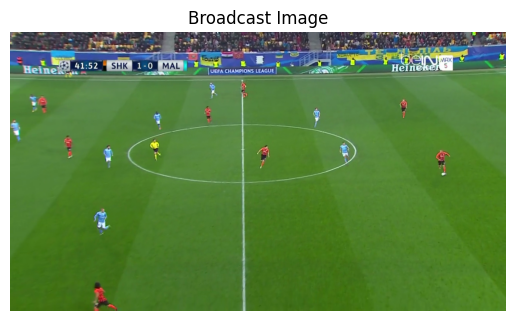

In [64]:
from matplotlib import image
import matplotlib.pyplot as plt

image_name = 'image_snjv_334.png'
for path in paths:
    temp_path = os.path.join(path, image_name)
    if os.path.exists(temp_path):
        image_path = temp_path
        break

if image_path is None:
    raise ValueError(f"Image file not found: {image_name}")

cap = cv2.imread(image_path)
cap = cv2.cvtColor(cap, cv2.COLOR_BGR2RGB)
plt.imshow(cap)
plt.title('Broadcast Image')
plt.axis('off')
plt.show()

In [65]:
viz_df = label_df[label_df['image_name'] == image_name].copy()
viz_df.loc[viz_df['gnd_y'] > 68, 'gnd_y'] = 66
viz_df

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,gnd_x,gnd_y
2287,0,0,0,1,0.064844,0.259722,0.019531,0.062500,image_snjv_334.png,1,37.0,12.0
2288,0,0,0,0,0.046875,0.254167,0.016406,0.065278,image_snjv_334.png,2,36.0,12.0
2289,0,0,1,1,0.191406,0.947222,0.050781,0.105556,image_snjv_334.png,3,49.0,66.0
2290,1,NaN,NaN,NaN,0.874891,0.512306,0.015656,0.027833,image_snjv_334.png,4,72.0,39.0
2291,0,0,0,1,0.472648,0.205250,0.019828,0.066778,image_snjv_334.png,5,57.0,6.0
2292,0,0,0,0,0.197656,0.445833,0.019531,0.084722,image_snjv_334.png,6,46.0,36.0
2293,0,0,0,0,0.617969,0.306944,0.014844,0.075000,image_snjv_334.png,7,64.0,21.0
2294,0,0,0,2,0.292187,0.422222,0.022656,0.080556,image_snjv_334.png,8,50.0,33.0
2295,0,0,0,1,0.117188,0.411111,0.017969,0.086111,image_snjv_334.png,9,42.0,32.0
2296,0,0,0,0,0.184375,0.680556,0.033594,0.100000,image_snjv_334.png,10,47.0,55.0


In [66]:
# Template Image of Soccer Field
w = cap.shape[1] #1280
h = cap.shape[0] #720

bg_ratio = int(np.ceil(w/(3*105)))
gt_img = cv2.imread('PerspectiveTransform/inference/black.jpg')
gt_img = cv2.resize(gt_img,(105*bg_ratio, 68*bg_ratio))
gt_h, gt_w, _ = gt_img.shape

bg_img = gt_img.copy()


In [69]:
M, warped_image = perspective_transform.homography_matrix(cap)

In [73]:
main_frame = cap.copy()
H = main_frame.shape[0]
W = main_frame.shape[1]

for index, row in viz_df.iterrows():
    bbox = [row['x']-(row['w']/2), row['y']-(row['h']/2), row['w'], row['h']]
    
    x = int(bbox[0]*W)
    y = int(bbox[1]*H)
    w = int(bbox[2]*W)
    h = int(bbox[3]*H)
    
    coords = (int(row['gnd_x']*bg_ratio), int(row['gnd_y']*bg_ratio))
    
    #Player
    if (row['class'] == 0):
        #coords : (x,y); (0,0) -> tl
        if(int(row['team']) == 0):
            cv2.circle(bg_img, coords, bg_ratio + 1, (0,85,255), -1)
            cv2.rectangle(main_frame, (x, y), (x + w, y + h), (0,85,255), 2)
            
        elif(int(row['team']) == 1):
            cv2.circle(bg_img, coords, bg_ratio + 1, (255,0,85), -1)
            cv2.rectangle(main_frame, (x, y), (x + w, y + h), (255,0,85), 2)
        else:
            cv2.circle(bg_img, coords, bg_ratio + 1, (128,128,128), -1)
            cv2.rectangle(main_frame, (x, y), (x + w, y + h), (128,128,128), 2)
    #Ball
    elif (row['class'] == 1):
        cv2.circle(bg_img, coords, bg_ratio + 1, (255,255,0), -1)
        cv2.rectangle(main_frame, (x, y), (x + w, y + h), (255, 255, 0), 2)
        cv2.putText(main_frame, 'ball', (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)



(-0.5, 524.5, 339.5, -0.5)

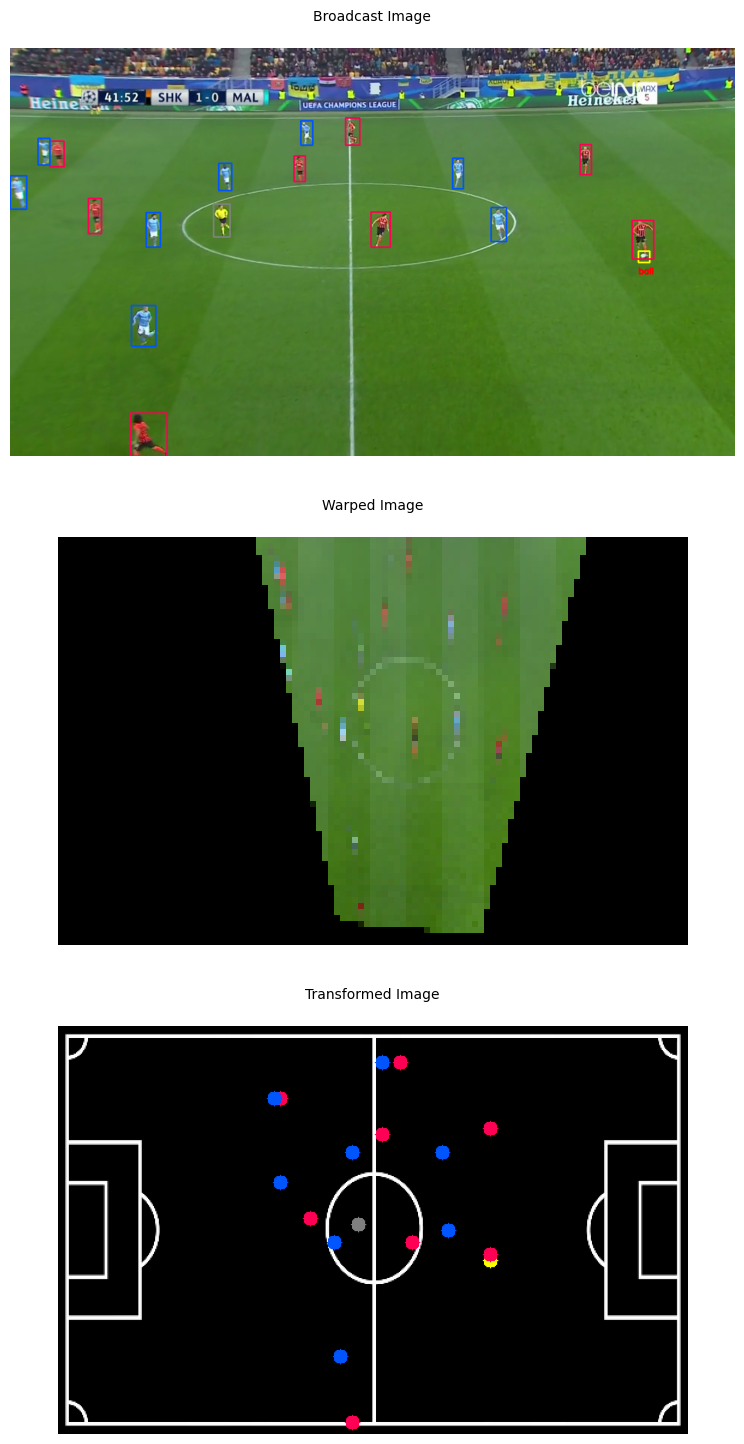

In [80]:
fig, axes = plt.subplots(3,1, figsize=(30, 18))

# Plot the broadcast image
axes[0].imshow(main_frame)
axes[0].set_title('Broadcast Image', fontsize=10, pad=20)
axes[0].axis('off')

# Plot the warped image
axes[1].imshow(warped_image)
axes[1].axis('off')
axes[1].set_title('Warped Image',fontsize=10, pad=20)

# Plot the Transformed image in the second subplot
axes[2].imshow(bg_img)
axes[2].set_title('Transformed Image', fontsize=10, pad=20)
axes[2].axis('off')


The results show that perspective transformation allows us to obtain approximate ground coordinates for each of the bounding boxes present in the image (as visualized above for each player and the ball.) After obtaining the ground coordinates, we determine the current ball dribbler (ball_possession = 1) by taking the player with the minimum euclidean distance to the ball coordinates.